# Notebook used to estimate epidemic waves

In [1]:
import pandas as pd
from functools import reduce
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.stats import skewnorm
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('data/waves/world_r_eff.csv',
        usecols=['country','date','R'],
        squeeze=True
        ).sort_index()
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

In [3]:
trend_length = 14
logic_func = lambda r: reduce(lambda x, y: x + 1 if y else 0, r)

In [4]:
df_total = pd.DataFrame(columns=['country',	'date',	'R', 'upward_slope_days', 'downward_slope_days' ])
for country in tqdm(df.country.unique()):
    df_country = df.loc[df['country'] == country]
    
    # counts number consecutive days with R>=1 for a give date
    ser = df.loc[df['country'] == country]['R'] > 1
    df_country['upward_slope_days'] = ser.expanding().apply(logic_func)

    # counts number consecutive days with R<1 for a give date
    ser = df_country['R'] < 1
    df_country['downward_slope_days'] = ser.expanding().apply(logic_func)

    #df_country = df_country[(df_country.upward_slope_days > 14) | (df_country.downward_slope_days > 14)]
    # append df to total_df
    df_total = pd.concat([df_total, df_country])
df_total = df_total[~df_total.country.isin(df_total[df_total.R < 0.10].country.unique())]
df_total = df_total[~df_total.country.isin(df_total[df_total.R > 3.06].country.unique())]
df_total = df_total[df_total.country != 'World']
df_total = df_total.reset_index().drop('index', axis=1)

100%|██████████| 182/182 [00:11<00:00, 15.51it/s]


In [5]:
ser = df_total['upward_slope_days'] >= 14
mask1 = df_total.index.isin(df_total['upward_slope_days'][ser & (ser != ser.shift(-1))].index)
ser = df_total['downward_slope_days'] >= 14
mask2 = df_total.index.isin(df_total['downward_slope_days'][ser & (ser != ser.shift(-1))].index)
df_wave = df_total[mask1 | mask2]

In [6]:
df_new = pd.DataFrame(columns=list(df_total.columns) + ['upward_period', 'downward_period'])
current_country = ""
slope_count = 1.0
mask = df_total['upward_slope_days'] >= 14
ix = df_total['upward_slope_days'][mask & (mask != mask.shift(-1))].index
for i in tqdm(ix):
    new_country = df_total.iloc[i].country
    if current_country != new_country:
        slope_count = 1.0
        current_country = new_country
    val = int(df_total.iloc[i]['upward_slope_days'])
    first_ix = i-val+1
    df_temp = df_total.iloc[first_ix:i+1]
    df_temp['upward_period'] = slope_count
    df_temp['downward_period'] = np.nan
    df_new = pd.concat([df_new, df_temp], ignore_index=True)
    slope_count += 1.0
mask = df_total['downward_slope_days'] >= 14
ix = df_total['downward_slope_days'][mask & (mask != mask.shift(-1))].index
for i in tqdm(ix):
    new_country = df_total.iloc[i].country
    if current_country != new_country:
        slope_count = 1.0
        current_country = new_country
    val = int(df_total.iloc[i]['downward_slope_days'])
    first_ix = i-val+1
    df_temp = df_total.iloc[first_ix:i+1]
    df_temp['upward_period'] = np.nan
    df_temp['downward_period'] = slope_count
    df_new = pd.concat([df_new, df_temp], ignore_index=True)
    slope_count += 1.0

countries = df_total.country.unique()
for c in tqdm(countries):
    df_total_country = df_total[df_total.country == c]
    df_new_country = df_new[df_new.country == c]
    neutral_dates = set(df_total_country.date) - set(df_new_country.date)
    mask1 = df_total.country == c
    mask2 = df_total.date.isin(neutral_dates)
    df_temp = df_total[mask1 & mask2]
    empty_series = np.empty(len(df_temp))
    empty_series[:] = np.nan
    df_temp['upward_period'] = empty_series
    df_temp['downward_period'] = empty_series
    dt = df_temp.date
    in_block = dt - dt.shift(1) == pd.Timedelta('1d')
    df_temp['neutral_period'] = np.zeros(len(df_temp))
    ix = in_block[~in_block].index
    for i in ix:
        df_temp.at[i, 'neutral_period'] = 1.0
    df_temp['neutral_period'] = np.cumsum(df_temp['neutral_period'])
    df_new = pd.concat([df_new, df_temp], ignore_index=True)
df_new = df_new.sort_values(by=['country', 'date']).reset_index().drop('index', axis=1)
mask1 = df_new.neutral_period > 0
mask2 = df_new.upward_period > 0
mask3 = df_new.downward_period > 0
is_neutral = pd.Series(mask1 & ~(mask2 | mask3))
func = lambda r: reduce(lambda x,y: x + 1 if y else 0, r)
tqdm.pandas()
df_new['neutral_slope_days'] = is_neutral.expanding().progress_apply(func)

100%|██████████| 153/153 [00:02<00:00, 61.99it/s]
57409it [05:37, 170.04it/s]


In [7]:
df_new = df_new[['country', 'date', 'R', 'upward_slope_days','upward_period','downward_slope_days','downward_period','neutral_slope_days','neutral_period']]
df_new.to_csv('data/waves/world_wave_data.csv', index=False)
df_full = df_new

In [8]:
# Drop entries where wavecount > 6
mask1 = df_full.upward_period < 7
mask2 = df_full.downward_period < 7
mask3 = df_full.neutral_period < 7
df_new = df_new[mask1 | mask2 | mask3]

In [9]:
ser = df_new['upward_slope_days'] >= 14
mask1 = df_new.index.isin(df_new['upward_slope_days'][ser & (ser != ser.shift(-1))].index)
ser = df_new['downward_slope_days'] >= 14
mask2 = df_new.index.isin(df_new['downward_slope_days'][ser & (ser != ser.shift(-1))].index)
ser = df_new['neutral_slope_days'] > 0
mask3 = df_new.index.isin(df_new['neutral_slope_days'][ser & (ser != ser.shift(-1))].index)
df_wave = df_new[mask1 | mask2 | mask3]

In [10]:
df_count = df_wave[['country','upward_period', 'downward_period', 'neutral_period']]
df_count['upward_period'] = df_count['upward_period'].apply(lambda x: True if x > 0 else False)
df_count['downward_period'] = df_count['downward_period'].apply(lambda x: True if x > 0 else False)
df_count['neutral_period'] = df_count['neutral_period'].apply(lambda x: True if x > 0 else False)
count_matrix = {
    "U": {
        "U": 0,
        "D": 0,
        "N": 0
    },
    "D": {
        "U": 0,
        "D": 0,
        "N": 0
    },
    "N":{
        "U": 0,
        "D": 0,
        "N": 0
    }
}
for c in tqdm(df_count.groupby('country')):
    df = c[1]
    previous = ""
    for i, row in enumerate(df.iterrows()):
        info = row[1]
        current = ""
        if info.upward_period:
            current = "U"
        elif info.downward_period:
            current = "D"
        elif info.neutral_period:
            current = "N"
        if previous and previous != current:
            count_matrix[previous][current] += 1
        previous = current

wave_transition_df = pd.DataFrame(count_matrix)
wave_transition_df = wave_transition_df/wave_transition_df.sum(axis=1).to_numpy().reshape(-1,1)

100%|██████████| 153/153 [00:00<00:00, 889.54it/s]


In [11]:
wave_transition_df.to_csv('data/waves/wave_transition.csv')

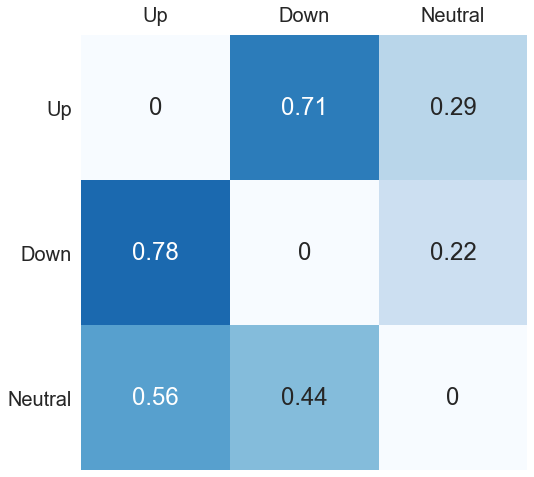

In [12]:
col_labels = ["Up", "Down", "Neutral"]
transition_matrix = wave_transition_df.values
sns.set(font_scale=2)
plt.figure(figsize=(8,8))
sns.heatmap(np.round(transition_matrix,2), vmin=0, vmax=1, annot=True, cmap="Blues", xticklabels=col_labels, yticklabels=col_labels, cbar=False)
plt.tick_params(axis='both', which='major', labelsize=20, labelbottom=False, bottom=False, top=False, labeltop=True)
plt.yticks(rotation=0)
plt.savefig("plots/waves/transition_matrix.png",dpi=200)
plt.show()

In [13]:
df_up = df_wave[df_wave.upward_period > 0].drop(['downward_period', 'downward_slope_days', 'neutral_slope_days', 'neutral_period'], axis=1)
df_down = df_wave[df_wave.downward_period > 0].drop(['upward_period', 'upward_slope_days', 'neutral_slope_days', 'neutral_period'], axis=1)
df_neutral = df_wave[df_wave.neutral_period > 0].drop(['upward_period', 'upward_slope_days','downward_period', 'downward_slope_days'], axis=1)

In [28]:
df_up

,country,date,R,upward_slope_days,upward_period
73,Afghanistan,2020-06-10,1.006454,74.0,1.0
175,Afghanistan,2020-09-20,1.024770,16.0,2.0
248,Afghanistan,2020-12-02,1.007850,63.0,3.0
394,Afghanistan,2021-04-27,1.432876,54.0,4.0
549,Albania,2020-08-25,1.021914,97.0,1.0
...,...,...,...,...,...
56730,Zambia,2020-05-19,1.014861,19.0,1.0
56993,Zambia,2021-02-06,1.002719,82.0,2.0
57146,Zimbabwe,2020-08-08,1.016000,73.0,1.0
57309,Zimbabwe,2021-01-18,1.027442,98.0,2.0


In [44]:
up = df_up.groupby(['upward_period'], as_index=False).mean()
down = df_down.groupby(['downward_period'], as_index=False).mean()
neutral = df_neutral.groupby(['neutral_period'], as_index=False).mean()
neutral


,neutral_period,R,neutral_slope_days
0,1.0,1.000373,10.327273
1,2.0,1.001546,11.264706
2,3.0,0.996542,12.257143
3,4.0,1.001354,13.277778
4,5.0,0.992037,11.750000
5,6.0,1.023708,11.000000


In [14]:
up_R_params = df_new.groupby(['upward_period']).aggregate({"R": ["count", "mean", "min", "max", "skew", "std"]})
up_R_params.columns = up_R_params.columns.get_level_values(1)
up_R_params.index = up_R_params.index.astype(int)

down_R_params = df_new.groupby(['downward_period']).aggregate({"R": ["count", "mean", "min", "max", "skew", "std"]})
down_R_params.columns = down_R_params.columns.get_level_values(1)
down_R_params.index = down_R_params.index.astype(int)

neutral_R_params = df_new.groupby(['neutral_period']).aggregate({"R": ["count", "mean", "min", "max", "skew", "std"]})
neutral_R_params.columns = neutral_R_params.columns.get_level_values(1)
neutral_R_params.index = neutral_R_params.index.astype(int)

In [74]:
# Write to CSV
# up_R_params.to_excel('R_params.xlsx', 'Neutral')
#down_R_params.to_excel('R_params.xlsx','Upward')
neutral_R_params.to_excel('R_params.xlsx','Downward')

In [15]:
up_period_params = df_up.groupby(['upward_period']).aggregate({"upward_slope_days": ["count","mean","min", "max", "skew", "std"]})
up_period_params.columns = up_period_params.columns.get_level_values(1)
up_period_params.index = up_period_params.index.astype(int)

down_period_params = df_down.groupby(['downward_period']).aggregate({"downward_slope_days": ["count","mean","min", "max", "skew", "std"]})
down_period_params.columns = down_period_params.columns.get_level_values(1)
down_period_params.index = down_period_params.index.astype(int)

neutral_period_params = df_neutral.groupby(['neutral_period']).aggregate({"neutral_slope_days": ["count","mean","min", "max", "skew", "std"]})
neutral_period_params.columns = neutral_period_params.columns.get_level_values(1)
neutral_period_params.index = neutral_period_params.index.astype(int)

In [70]:
# Write to CSV
# neutral_period_params.to_excel('duration_params.xlsx', 'Neutral')
up_period_params.to_excel('duration_params.xlsx','Upward')
#down_period_params.to_excel('duration_params.xlsx','Downward')

In [16]:
data = {}
R = {}
labels = ['U', 'D', 'N']
for i, df in enumerate([up_R_params, down_R_params, neutral_R_params]):
    R[labels[i]] = json.loads(df.to_json(orient='index'))
duration = {}
for i, df in enumerate([up_period_params, down_period_params, neutral_period_params]):
    duration[labels[i]] = json.loads(df.to_json(orient='index'))
data['R'] = R
data['duration'] = duration

In [17]:
with open('data/waves/wave_parameters.json', 'w') as file:
    json.dump(data, file, indent=4)

In [ ]:
pandas

In [18]:
ser = df_new['upward_slope_days'] > 14
up = df_new['upward_slope_days'][ser & (ser != ser.shift(-1))].to_frame().reset_index().drop('index', axis=1).rename(columns={'upward_slope_days':'days'})
up['slope'] = pd.Series(['Upward' for _ in range(len(up))])

ser = df_new['downward_slope_days'] > 14
down = df_new['downward_slope_days'][ser & (ser != ser.shift(-1))].to_frame().reset_index().drop('index', axis=1).rename(columns={'downward_slope_days':'days'})
down['slope'] = pd.Series(['Downward' for _ in range(len(down))])

ser = df_new['neutral_slope_days'] > 0
neutral = df_new['neutral_slope_days'][ser & (ser != ser.shift(-1))].to_frame().reset_index().drop('index', axis=1).rename(columns={'neutral_slope_days':'days'})
neutral['slope'] = pd.Series(['Neutral' for _ in range(len(neutral))])

df_dist = pd.concat([up, down, neutral])

<Figure size 842.4x595.44 with 0 Axes>

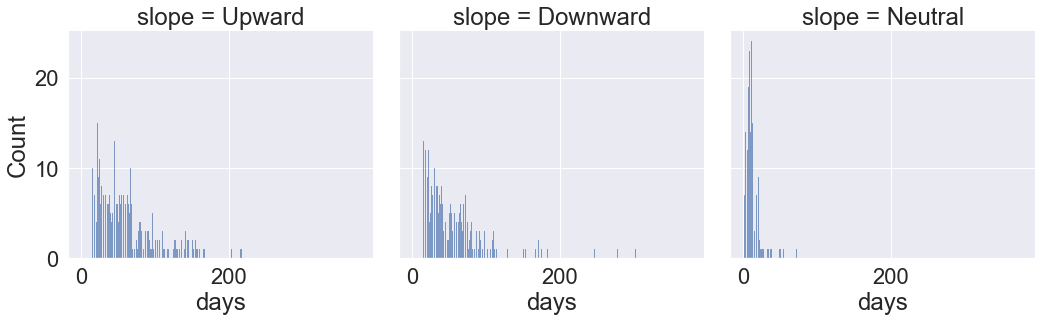

In [19]:
a4_dims = (11.7, 8.27)
plt.figure(figsize=a4_dims)
sns.displot(df_dist, x='days', col='slope', kind='hist', fill=True, height=5, aspect=1, bins=len(up))
plt.show()

<Figure size 842.4x595.44 with 0 Axes>

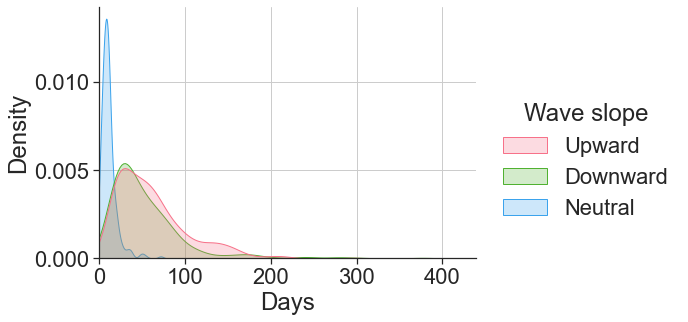

In [20]:
sns.set_style("ticks")
a4_dims = (11.7, 8.27)
plt.figure(figsize=a4_dims)
ax = sns.displot(df_dist, x='days', hue='slope', kind='kde', fill=True, aspect=1.5, palette="husl")
ax._legend.set_title("Wave slope")
ax.set(xlabel="Days")
plt.xlim(0)
plt.grid()
plt.savefig("plots/waves/wave_duration.png", dpi=200)
plt.show()

## Duration

In [21]:
df_new[df_new.upward_period > 0].groupby(['upward_period','upward_slope_days']).R.describe()

count      mean       std       min  \
upward_period upward_slope_days                                        
1.0           1.0                152.0  1.501164  0.541999  1.000027   
              2.0                152.0  1.517212  0.529772  1.005931   
              3.0                152.0  1.534238  0.518610  1.011044   
              4.0                152.0  1.548918  0.511952  1.017609   
              5.0                152.0  1.561300  0.503575  1.021679   
...                                ...       ...       ...       ...   
6.0           64.0                 1.0  1.243402       NaN  1.243402   
              65.0                 1.0  1.178294       NaN  1.178294   
              66.0                 1.0  1.123725       NaN  1.123725   
              67.0                 1.0  1.070261       NaN  1.070261   
              68.0                 1.0  1.018131       NaN  1.018131   

                                      25%       50%       75%       max  
upward_period upward_slope_days                                          
1.0           1.0                1.054044  1.296607  1.777474  2.989860  
              2.0                1.099898  1.288079  1.756184  2.984207  
              3.0                1.133715  1.345368  1.789351  2.981374  
              4.0                1.163363  1.338437  1.827211  3.054147  
              5.0                1.181629  1.351541  1.855916  3.020933  
...                                   ...       ...       ...       ...  
6.0           64.0               1.243402  1.243402  1.243402  1.243402  
              65.0               1.178294  1.178294  1.178294  1.178294  
              66.0               1.123725  1.123725  1.123725  1.123725  
              67.0               1.070261  1.070261  1.070261  1.070261  
              68.0               1.018131  1.018131  1.018131  1.018131  

[1069 rows x 8 columns]

In [58]:
v = df_new[df_new.upward_period > 0].groupby(['upward_period','upward_slope_days']).R.describe()
v.to_csv('test.csv')

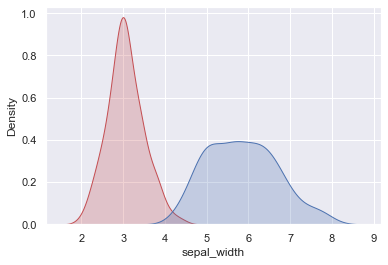

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
df = sns.load_dataset('iris')
 
# plotting both distibutions on the same figure
fig = sns.kdeplot(df['sepal_width'], shade=True, color="r")
fig = sns.kdeplot(df['sepal_length'], shade=True, color="b")
plt.show()

In [49]:
# Upward trend
d = []
df = df_up[['upward_slope_days', 'upward_period']]
for i, value in enumerate(df.upward_period.unique()):
    d.append(df_up[df.upward_period == value])
    
colors = sns.color_palette('Set2')
fig = plt.figure(figsize=(12,5))
sns.set(font_scale=1.1)
sns.set_style("ticks")

for i in range(len(d)):
    ax = sns.distplot(d[i][['upward_slope_days']], hist=False, label=f'Upward trend {i+1}', color=sns.color_palette('Set2')[i])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set(xlabel="Days")

plt.xlim([15, 250])
plt.grid()
plt.legend()
plt.savefig("plots/waves/upward_period_duration.png", dpi=200)
plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

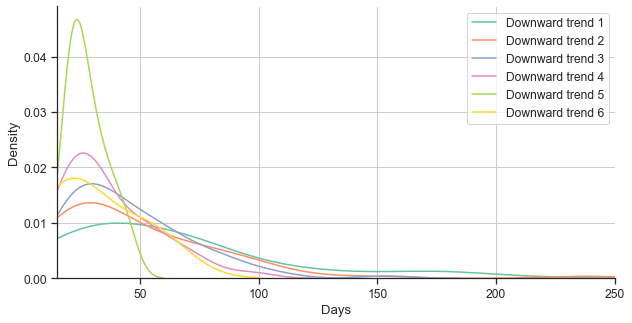

In [24]:
# Downward trend
d = []
df = df_down[['downward_slope_days', 'downward_period']]
for i, value in enumerate(df['downward_period'].unique()):
    d.append(df_down[df['downward_period'] == value])
    
colors = sns.color_palette('Set2')
fig = plt.figure(figsize=(10,5))
sns.set(font_scale=1.1)
sns.set_style("ticks")

for i in range(len(d)):
    ax = sns.distplot(d[i][['downward_slope_days']], hist=False, label=f'Downward trend {i+1}', color=sns.color_palette('Set2')[i])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set(xlabel="Days")

plt.xlim([15, 250])
plt.grid()
plt.legend()
plt.savefig("plots/waves/downward_period_duration.png", dpi=200)
plt.show()

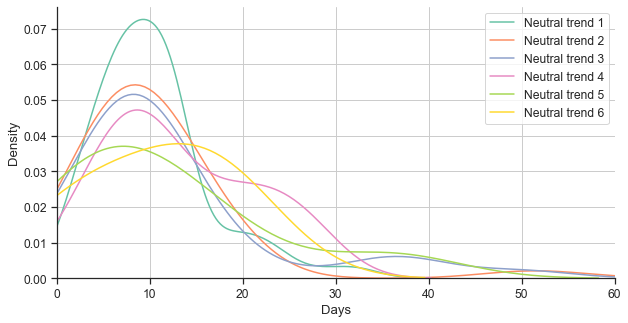

In [25]:
# Neutral trend
d = []
df = df_neutral[['neutral_slope_days', 'neutral_period']]
for i, value in enumerate(df['neutral_period'].unique()):
    d.append(df_neutral[df['neutral_period'] == value])
    
colors = sns.color_palette('Set2')
fig = plt.figure(figsize=(10,5))
sns.set(font_scale=1.1)
sns.set_style("ticks")

for i in range(len(d)):
    ax = sns.distplot(d[i][['neutral_slope_days']], hist=False, label=f'Neutral trend {i+1}', color=sns.color_palette('Set2')[i])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set(xlabel="Days")

plt.xlim([0,60])
plt.grid()
plt.legend()
plt.savefig("plots/waves/neutral_period_duration.png", dpi=200)
plt.show()

## Reproduction number

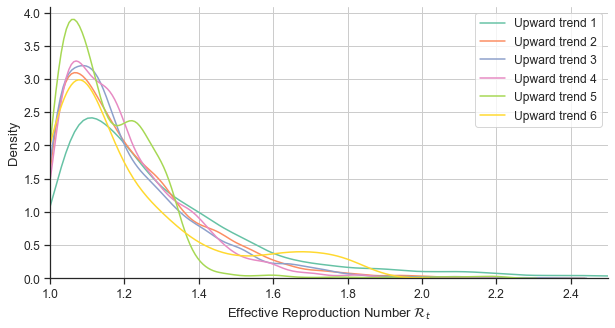

In [26]:
# Upward trend
d = []
df_upward = df_new[df_new['upward_period'] > 0]
for i, value in enumerate(df_upward['upward_period'].unique()):
    d.append(df_upward[df_upward['upward_period'] == value])
    
colors = sns.color_palette('Set2')
fig = plt.figure(figsize=(10,5))
sns.set(font_scale=1.1)
sns.set_style("ticks")

for i in range(len(d)):
    ax = sns.distplot(d[i][['R']], hist=False, label=f'Upward trend {i+1}', color=sns.color_palette('Set2')[i])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set(xlabel=r"Effective Reproduction Number $\mathcal{R}_t$")

plt.xlim([1,2.5])
plt.grid()
plt.legend()
plt.savefig("plots/waves/upward_period_r.png", dpi=200)
plt.show()

In [51]:
# Downward trend
d = []
df_down = df_new[df_new['downward_period'] > 0]
for i, value in enumerate(df_down['downward_period'].unique()):
    d.append(df_down[df_down['downward_period'] == value])
    
colors = sns.color_palette('Set2')
fig = plt.figure(figsize=(10,5))
sns.set(font_scale=1.1)
sns.set_style("ticks")

for i in range(len(d)):
    ax = sns.distplot(d[i][['R']], hist=False, label=f'Downward trend {i+1}', color=sns.color_palette('Set2')[i])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set(xlabel=r"Effective Reproduction Number $\mathcal{R}_t$")

plt.xlim([0, 1])
plt.grid()
plt.legend()
plt.savefig("plots/waves/downward_period_r.png", dpi=200)
plt.show()


RuntimeError: Failed to process string with tex because latex could not be found

In [52]:
# Neutral trend
d = []
df_neutral = df_new[df_new['neutral_period'] > 0]
for i, value in enumerate(df_neutral['neutral_period'].unique()):
    d.append(df_neutral[df_neutral['neutral_period'] == value])
    
colors = sns.color_palette('Set2')
fig = plt.figure(figsize=(10,5))
sns.set(font_scale=1.1)
sns.set_style("ticks")

for i in range(len(d)):
    ax = sns.distplot(d[i][['R']], hist=False, label=f'Neutral trend {i+1}', color=sns.color_palette('Set2')[i])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set(xlabel=r"Effective Reproduction Number $\mathcal{R}_t$")

plt.xlim([0.5, 1.5])
plt.grid()
plt.legend()
plt.savefig("plots/waves/neutral_period_r.png", dpi=200)
plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

In [55]:
from collections import Counter
horizon = 60
with open('data/waves/wave_parameters.json') as file:
    data = json.load(file)
transition_mat = pd.read_csv('data/waves/wave_parameters.json', index_col=0).T.to_dict()

R_timeline = np.ones(horizon)
current_state = 'U'
wave_state_history = []
i = 0
while True:
    wave_state_history.append(current_state)
    n_wave = Counter(wave_state_history)[current_state]
    params = data['duration'][current_state][str(n_wave)]
    duration = skewnorm.rvs(params['skew'], loc=params['mean'], scale=params['std']) // 7 # weeks
    duration = min(max(duration, params['min']), params['max'])
    try:
        for week in range(i, i+int(duration)):
            params = data['R'][current_state][str(n_wave)]
            R = skewnorm.rvs(params['skew'], loc=params['mean'], scale=params['std'])
            R = min(max(R, params['min']), params['max'])
            R_timeline[week] = R
        i += int(duration)
        current_state = np.random.choice(['U', 'D', 'N'], p=list(transition_mat[current_state].values()))
    except:
        print("Timeline generated")
        break

ParserError: Error tokenizing data. C error: Expected 1 fields in line 5, saw 2


In [56]:
df = pd.read_json('data/waves/wave_parameters.json')
df

,R,duration
U,"{'1': {'count': 9906, 'mean': 1.3092040025, 'm...","{'1': {'count': 152, 'mean': 65.1710526316, 'm..."
D,"{'1': {'count': 10328, 'mean': 0.7450610433, '...","{'1': {'count': 152, 'mean': 67.9473684211, 'm..."
N,"{'1': {'count': 1120, 'mean': 1.0177393161, 'm...","{'1': {'count': 110, 'mean': 10.3272727273, 'm..."
